In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import ParameterGrid

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import NMF

import re

In [5]:
train = pd.read_csv('C:/Users/josep/Downloads/learn-ai-bbc/BBC News Train.csv')
test = pd.read_csv('C:/Users/josep/Downloads/learn-ai-bbc/BBC News Test.csv')

print(train.head())
print(test.head())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


In [6]:
#Preprocessing text data by: removing special characters, removing white spaces, and converting all text to lowercase.
def preprocess_text(text):
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Preprocess text in both datasets
train['Text'] = train['Text'].apply(preprocess_text)
test['Text'] = test['Text'].apply(preprocess_text)

# Print data distributions
print("Training categories distribution:")
print(train['Category'].value_counts(normalize=True))
print("\nTest categories distribution:")
print(test['Category'].value_counts(normalize=True))

print("\nTraining text length statistics:")
print(train['Text'].str.len().describe())
print("\nTest text length statistics:")
print(test['Text'].str.len().describe())

Training categories distribution:
Category
sport            0.232215
business         0.225503
politics         0.183893
entertainment    0.183221
tech             0.175168
Name: proportion, dtype: float64

Test categories distribution:


KeyError: 'Category'

# Text Vectorization using TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) transforms text data into numerical format.

## Term Frequency (TF)
TF = o/t
- o: occurrences of term in document  
- t: total terms in document

## Inverse Document Frequency (IDF) 
IDF = log(d/c)
- d: total number of documents
- c: documents containing the term

## Final Score
TF-IDF = TF * IDF

This weights terms based on both their frequency in individual documents and their uniqueness across the document collection.

In [7]:
#This vectorizer tokenizes the input text, removes common stop-words, and applys the TF-IDF transformation.
vectorizer = TfidfVectorizer(
    sublinear_tf=True, 
    stop_words="english",
    ngram_range=(1, 2)
)

# I am limiting the fit to the training data to ensure the model is generizable when the same transformations are performed on a 
#new set of documents.
train_matrix = vectorizer.fit_transform(train['Text'])

In [8]:
nmf = NMF(n_components=5)
W = nmf.fit_transform(train_matrix)
H = nmf.components_

print("Original matrix shape:", train_matrix.shape)
print("W matrix shape:", W.shape)
print("H matrix shape:", H.shape)

Original matrix shape: (1490, 242972)
W matrix shape: (1490, 5)
H matrix shape: (5, 242972)


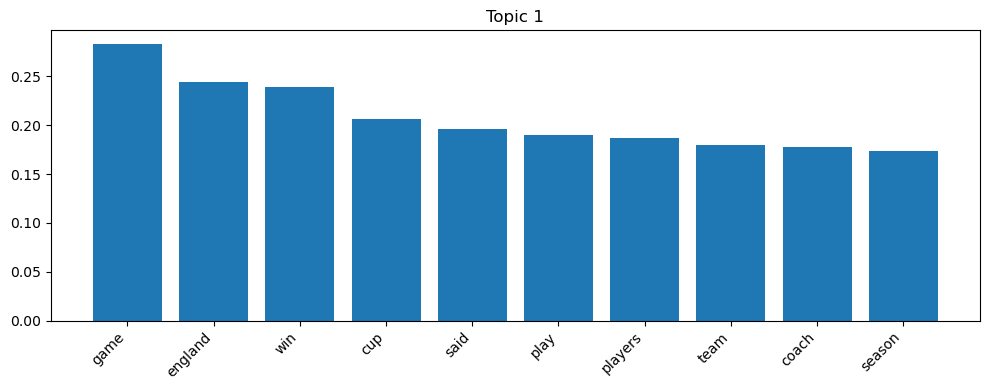

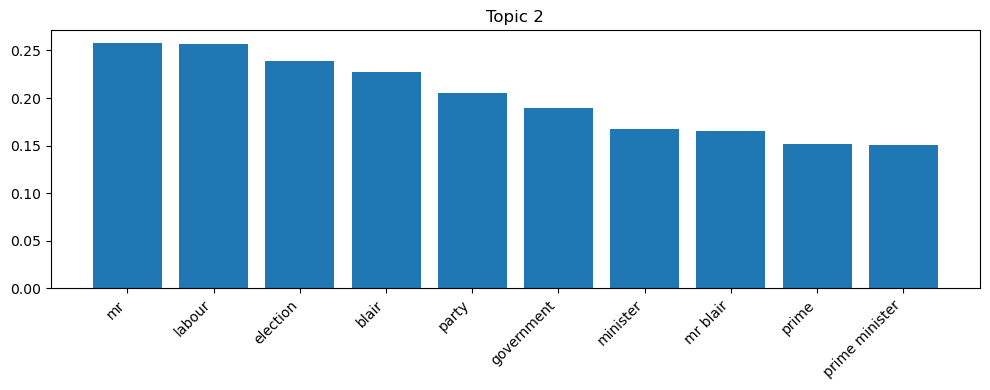

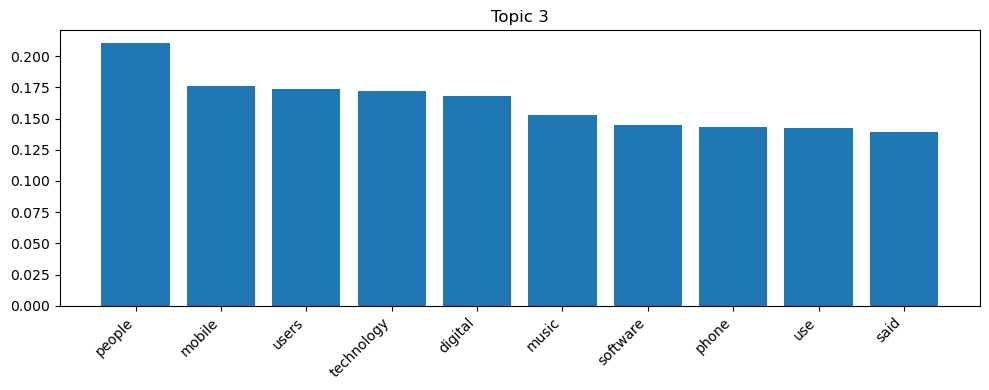

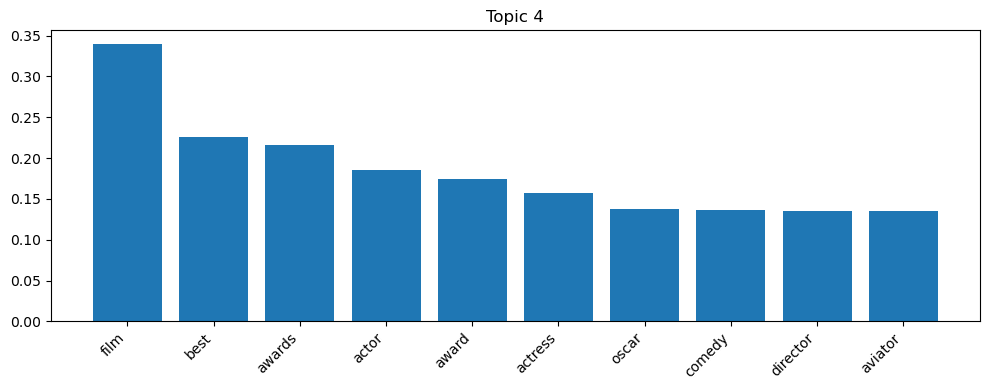

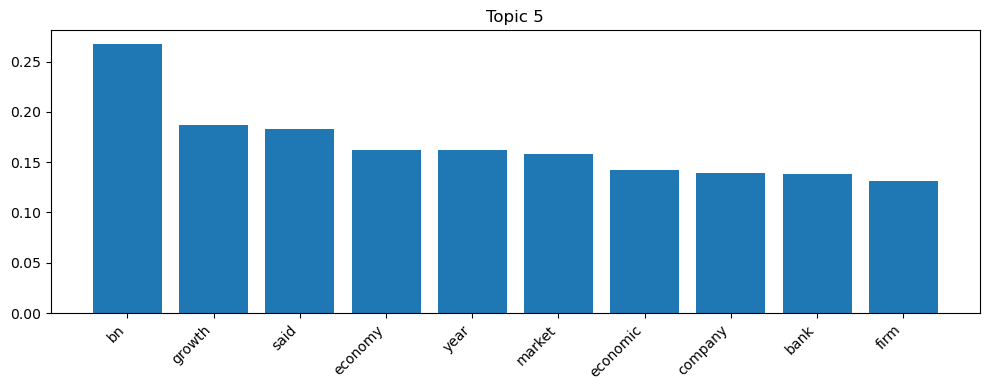

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topics(H, terms, n_top_words=10):
   for topic_idx, topic in enumerate(H):
       # Get top terms for this topic
       top_term_indices = topic.argsort()[-n_top_words:][::-1]
       top_terms = [terms[i] for i in top_term_indices]
       weights = topic[top_term_indices]
       
       # Create bar plot
       plt.figure(figsize=(10, 4))
       plt.bar(range(n_top_words), weights)
       plt.xticks(range(n_top_words), top_terms, rotation=45, ha='right')
       plt.title(f'Topic {topic_idx + 1}')
       plt.tight_layout()
       plt.show()
terms = vectorizer.get_feature_names_out()
plot_topics(nmf.components_, terms)

In [10]:
# Creating a mapping for labels and topics based on the top words from the above visalizations. The words in each topic clearly
# imply membership to particular categories.

topic_labels = {
   0: "sport", 
   1: "politics",
   2: "tech",
   3:"entertainment",
   4: "business",
}

topic_predictions = W.argmax(axis=1)

predicted_categories = [topic_labels[topic] for topic in topic_predictions]

print("\nValidation Results:")
print(f"Accuracy: {accuracy_score(train['Category'], predicted_categories):.3f}")
print("\nDetailed validation metrics:")
print(classification_report(train['Category'], predicted_categories))
#0.940 Accuracy on train data labels.


Validation Results:
Accuracy: 0.940

Detailed validation metrics:
               precision    recall  f1-score   support

     business       0.94      0.96      0.95       336
entertainment       0.98      0.82      0.89       273
     politics       0.95      0.95      0.95       274
        sport       0.98      0.99      0.98       346
         tech       0.86      0.96      0.91       261

     accuracy                           0.94      1490
    macro avg       0.94      0.94      0.94      1490
 weighted avg       0.94      0.94      0.94      1490



In [11]:
# Applying same transformations to test data.
test_matrix = vectorizer.transform(test['Text'])
W_test = nmf.transform(test_matrix)
topic_predictions_test = W_test.argmax(axis=1)

predicted_categories_test = [topic_labels[topic] for topic in topic_predictions_test]

result = pd.DataFrame({
    'ArticleId': test['ArticleId'],
    'Category': predicted_categories_test
})
result.to_csv('unsupervised_nmd_classification_result.csv', index=False)

#Submitted and got 0.94693 accuracy for test data predictions.  This indicates the model is generalizable!

The model with no hyperparameter tuning preformed quite well, but below is an example of hyperparameter tuning to find an even more accurate model.

C:\Users\josep\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
C:\Users\josep\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
C:\Users\josep\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
C:\Users\josep\anaconda3\Lib

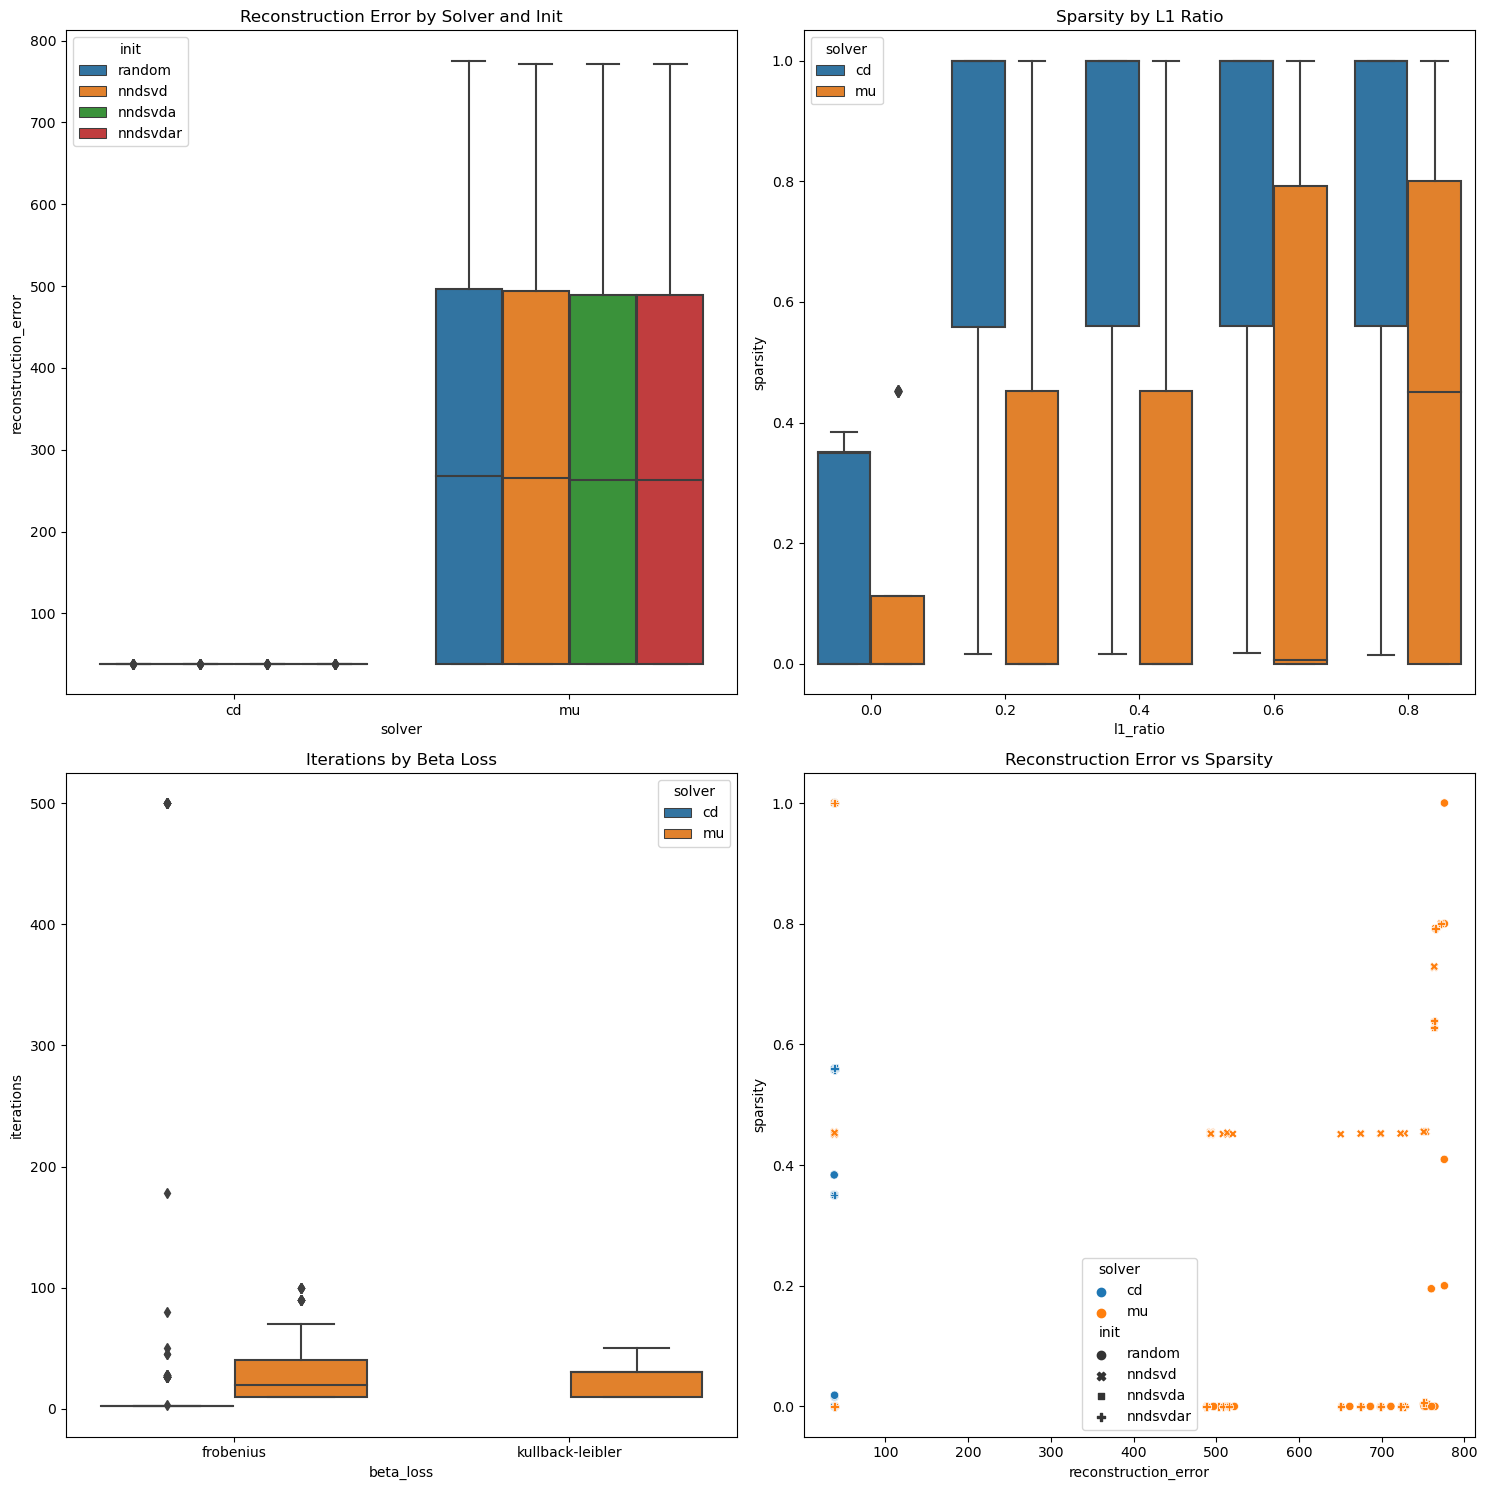


Top 10 parameter combinations by reconstruction error:
         init solver  beta_loss  l1_ratio  reconstruction_error  sparsity
0      random     cd  frobenius       0.0             38.161681  0.350470
3      random     cd  frobenius       0.2             38.161681  0.350336
12     random     cd  frobenius       0.8             38.161681  0.350470
60     random     cd  frobenius       0.0             38.161681  0.350470
18     nndsvd     cd  frobenius       0.2             38.161681  0.350470
21     nndsvd     cd  frobenius       0.4             38.161681  0.350470
27     nndsvd     cd  frobenius       0.8             38.161681  0.350470
24     nndsvd     cd  frobenius       0.6             38.161681  0.350470
15     nndsvd     cd  frobenius       0.0             38.161681  0.350470
105  nndsvdar     cd  frobenius       0.0             38.161681  0.350470


In [23]:
param_grid = {
    'init': ['random', 'nndsvd', 'nndsvda', 'nndsvdar'],
    'solver': ['cd', 'mu'],
    'l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8],
    'alpha_W': [0.0, 0.2, 0.4],
    'alpha_H': [0.0, 0.2, 0.4]
}

# Add beta_loss only for 'mu' solver
results = []
for params in ParameterGrid(param_grid):
    if params['solver'] == 'mu':
        beta_losses = ['frobenius', 'kullback-leibler']
    else:
        beta_losses = ['frobenius']
        
    for beta_loss in beta_losses:
        current_params = {**params, 'beta_loss': beta_loss}
        nmf = NMF(n_components=5, max_iter=500, **current_params)
        W = nmf.fit_transform(train_matrix)
        
        results.append({
            **current_params,
            'reconstruction_error': nmf.reconstruction_err_,
            'sparsity': np.mean(W == 0),
            'iterations': nmf.n_iter_,
            'converged': nmf.n_iter_ < nmf.max_iter
        })


df_results = pd.DataFrame(results)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Plot 1: Reconstruction error by solver and init
sns.boxplot(data=df_results, x='solver', y='reconstruction_error', 
            hue='init', ax=axes[0,0])
axes[0,0].set_title('Reconstruction Error by Solver and Init')

# Plot 2: Sparsity by l1_ratio
sns.boxplot(data=df_results, x='l1_ratio', y='sparsity', 
            hue='solver', ax=axes[0,1])
axes[0,1].set_title('Sparsity by L1 Ratio')

# Plot 3: Iterations until convergence
sns.boxplot(data=df_results, x='beta_loss', y='iterations', 
            hue='solver', ax=axes[1,0])
axes[1,0].set_title('Iterations by Beta Loss')

# Plot 4: Reconstruction error vs sparsity
sns.scatterplot(data=df_results, x='reconstruction_error', y='sparsity',
                hue='solver', style='init', ax=axes[1,1])
axes[1,1].set_title('Reconstruction Error vs Sparsity')

plt.tight_layout()
plt.show()

# Print top 10 combinations by reconstruction error
print("\nTop 10 parameter combinations by reconstruction error:")
print(df_results.sort_values('reconstruction_error').head(10)[
    ['init', 'solver', 'beta_loss', 'l1_ratio', 'reconstruction_error', 'sparsity']
])

#The result is a similar error for all coimbinations.  I purposfully chose these paramter types to test since the resulting 
#model would have the same components in the same order meaning the above implementation would apply.

# Comparison with supervised approach

In [ ]:
# Now for an attempt with a supervised approach, I'll use Singular Value Decompisition for dimensionality reduction to avoid
# overfitting.
svd = TruncatedSVD(n_components=1400)
train_reduced = svd.fit_transform(train_matrix)

print(train_reduced.shape)

In [87]:
# Prepare for training
train_labels = train['Category']

train_reduced_df = pd.DataFrame(train_reduced)

# Split into train and validation
X_train, X_validation, y_train, y_validation = train_test_split(
    train_reduced_df, 
    train_labels, 
    test_size=0.2, 
)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=10,
)

# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10)

In [88]:
# Validate on validation set
training_predictions = rf.predict(X_validation)
print("\nValidation Results:")
print(f"Accuracy: {accuracy_score(y_validation, training_predictions):.3f}")
print("\nDetailed validation metrics:")
print(classification_report(y_validation, training_predictions))


Validation Results:
Accuracy: 0.930

Detailed validation metrics:
               precision    recall  f1-score   support

     business       0.91      0.90      0.90        78
entertainment       0.91      0.98      0.94        50
     politics       0.92      0.94      0.93        48
        sport       0.98      1.00      0.99        64
         tech       0.92      0.84      0.88        58

     accuracy                           0.93       298
    macro avg       0.93      0.93      0.93       298
 weighted avg       0.93      0.93      0.93       298



In [ ]:
# Test on test set
test_predictions = rf.predict(pd.DataFrame(test_reduced))
test_predictions
test['result'] = test_predictions
result = pd.DataFrame({
    'ArticleId': test['ArticleId'],
    'Category': test_predictions
})
result.to_csv('classification_result.csv', index=False)

#This model resulted in Score: 0.96190 when submitted to Kaggle

Both the unsupervised and the supervised approaches led to highly accurate predictions on the testing data